# CMIP6 Ocean Atlas

#### Functions to compare hydrographic observations to models

![](sections_qc.png)

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Functions we created

- `get_stats` : calculates statistics between model and GLODAP. Corr., STD, normalized-STD, bias.
- `TaylorDiagram` : class to make Taylor diagrams 
- `model_to_line` : interpolates model values to sample locations
- `glodap_to_model` : interpolates samples to model vertical grid
- `plot_section` :  plotting function for the sections

In [2]:
from utils import model_to_line
from utils import glodap_to_model
from utils import regridder
from utils import get_stats
from utils import TaylorDiagram
from utils import plot_section

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
ovar_name = 'thetao'
cruise_line = 'A01W OVIDE'

In [4]:
expc = pd.read_csv(f'../qc/FILTERED_GLODAP_EXPOCODE.csv')
coords = pd.read_csv('../qc/GLODAPv2.2019_COORDS.csv')
glodap = pd.read_csv('../qc/GLODAPv2.2019_Merged_Master_File.csv')

In [5]:
cruise_id = expc[expc.LINE=='A01W OVIDE'].ID.values[0]
cruise_id

1047

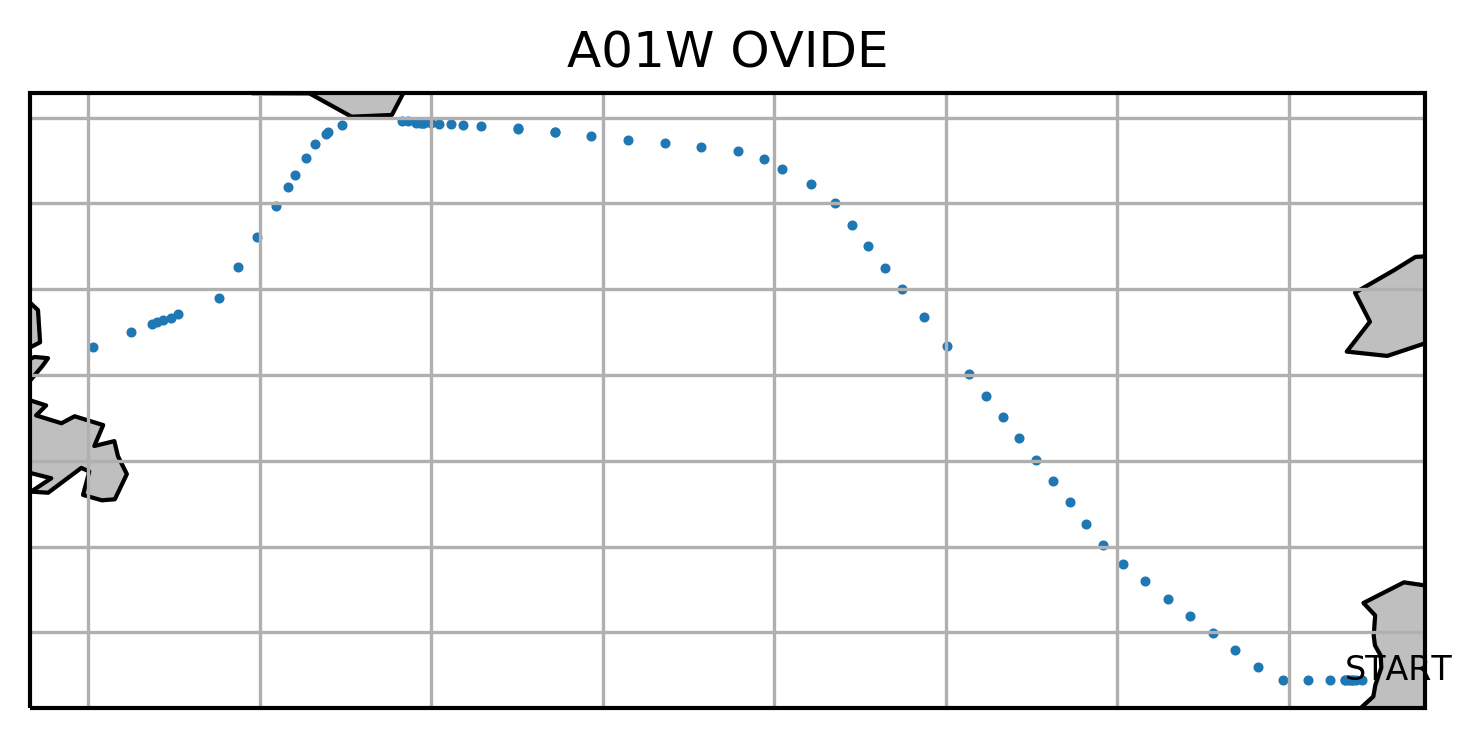

In [6]:
import cartopy as cart

lon = coords[coords.cruise==cruise_id].longitude
lat = coords[coords.cruise==cruise_id].latitude

fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=cart.crs.PlateCarree())

ax.set_title(cruise_line)
C = ax.scatter(lon,lat, transform=cart.crs.PlateCarree(),s=2)

plt.text(lon.values[0], lat.values[0],'START',
             transform = cart.crs.PlateCarree(),
             fontsize=8)

ax.add_feature(cart.feature.LAND, facecolor='0.75')
ax.coastlines()
gl = ax.gridlines()

# Calculate stats

In [7]:
%%capture

samples = []

model_color = {'CanESM5':'cyan',
               'MIROC-ES2L':'g',
               'UKESM1-0-LL':'b',
#                'CESM2':'k', <--- cgs to si unit issue
               'GISS-E2-1-G-CC':'k',
              }

for model in model_color.keys():
    
    print(model)

   
    ds_model = model_to_line(ovar_name=ovar_name,
                    model=model,
                    cruise_line=cruise_line,
                    catalog_path='../../catalogs/pangeo-cmip6.json',
                    qc_path='../qc',
                    output_path='../../sections')
    
    ds_obs = glodap_to_model(cruise_id,glodap,coords,expc,ovar_name,model,output_path='../../sections')

    # input dictionary
    input_dict = {'model': model,
                   'ovar': ovar_name,
                   'ds_obs' : ds_obs,
                   'ds_mod' : ds_model}

    # get dictionary of statistics 
    stats_dict = get_stats(dict_params=input_dict)

    # show the stats
    stats_dict
    
    model_stats = [stats_dict['std_norm'], stats_dict['corr'],  stats_dict['model'], model_color[model]]
    
    samples.append(model_stats)

In [8]:
samples

[[1.1365108891702258, 0.8767822387647021, 'CanESM5', 'cyan'],
 [1.0550029721802265, 0.8301951329382014, 'MIROC-ES2L', 'g'],
 [0.9546213985757296, 0.9120882440385044, 'UKESM1-0-LL', 'b'],
 [0.929815763858487, 0.9425304696323367, 'GISS-E2-1-G-CC', 'k']]

# Generate Taylor diagram

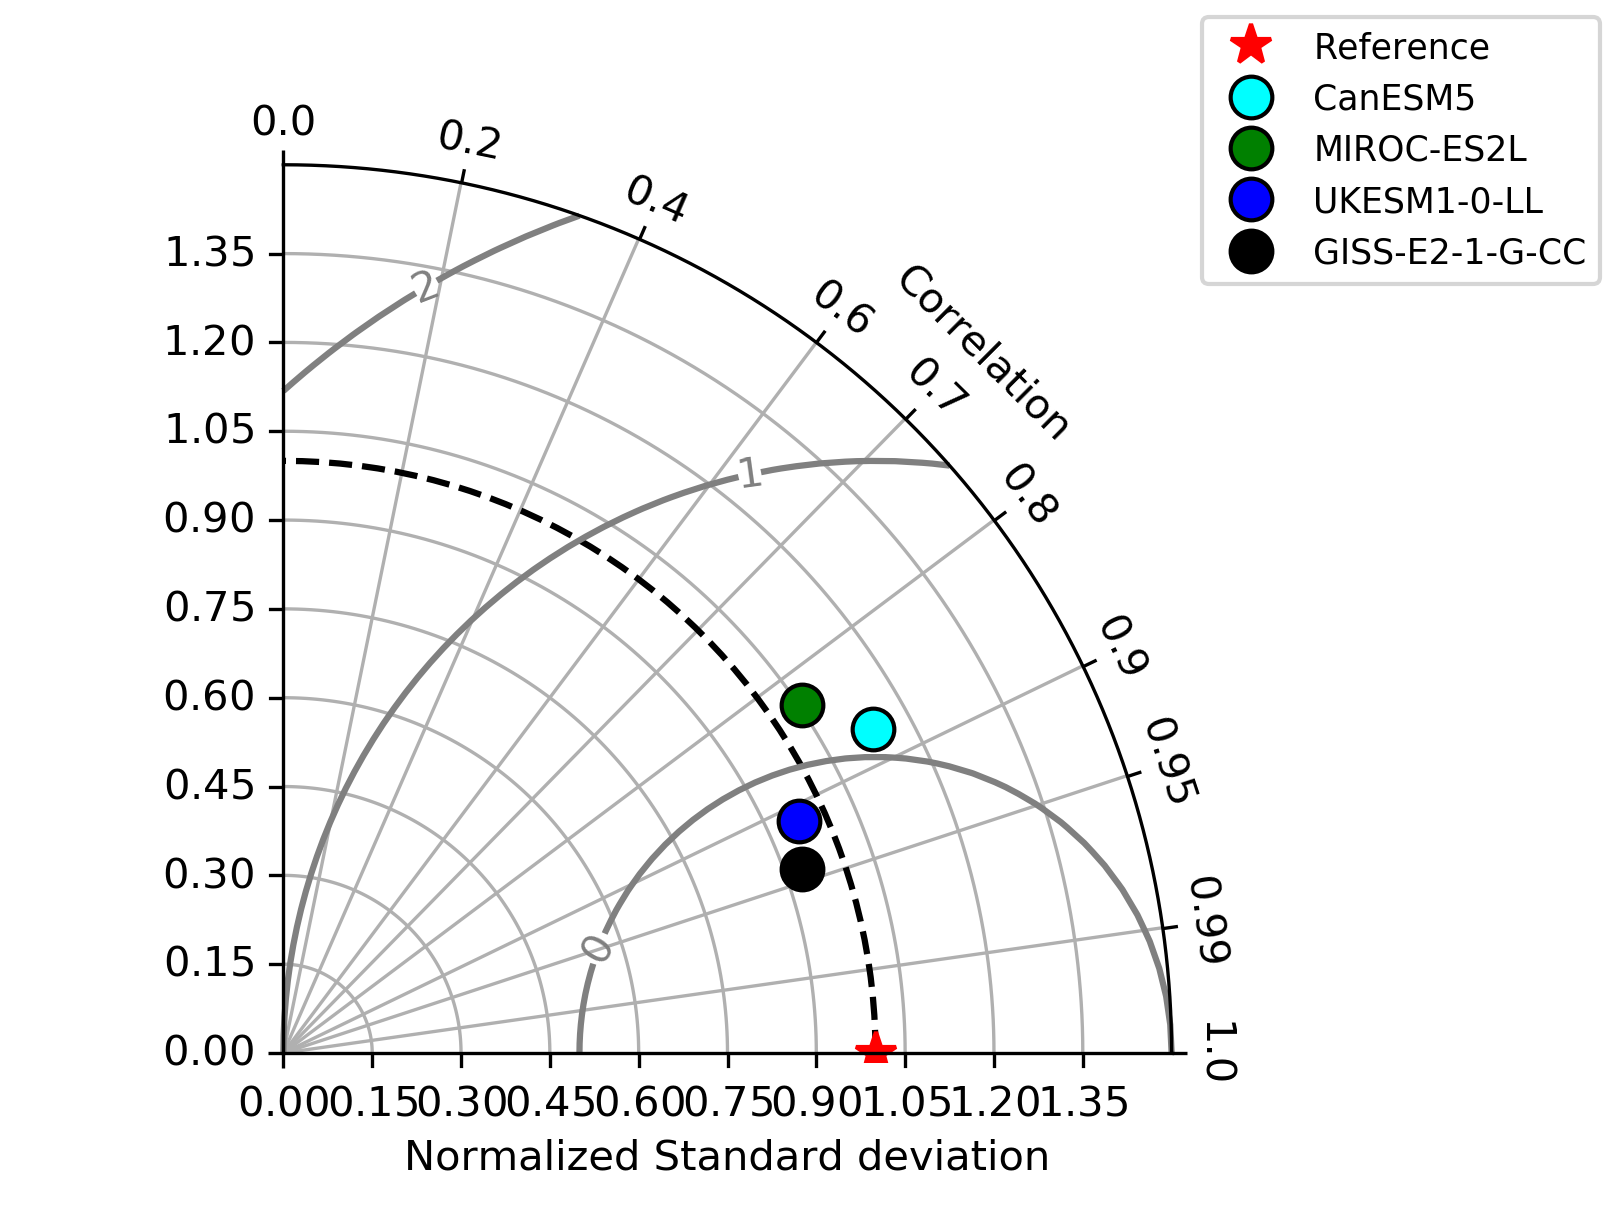

In [9]:
# Reference options 
ref_std = 1
ref_color = 'r'
ref_label = 'Reference'

# Samples list (maybe make a dictionary)
# -----------------------------------
#         std   rho   model  color
# -----------------------------------
#samples = [[stats_dict['std_norm'], stats_dict['corr'],  stats_dict['model'], 'g']]
# samples list is created above

#===============================
# Generate Taylor Diagram
#===============================
fig = plt.figure(dpi=300)

# generate Taylor diagram object 
dia = TaylorDiagram(refstd=ref_std, label=ref_label, extend=False, fig=fig)

# mark reference point as a red star
dia.samplePoints[0].set_color(ref_color)  

# add models to Taylor diagram
for i, (stddev, corrcoef, name, col) in enumerate(samples):
    dia.add_sample(stddev, corrcoef,
                   marker='o', ms=10, ls='',
                   mfc=col, mec='k',
                   label=name)

#===============================
# RMSE contours 
# Levels : number RMSE lines 
# color  : color of contours gray
#===============================
# Add RMS contours, and label them
contours = dia.add_contours(levels=3, colors='0.5') 

# add labelto RMSE contours 
dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.0f')

# Add grid lines 
dia.add_grid()                              

# Put ticks outward
dia._ax.axis[:].major_ticks.set_tick_out(True)  

# Add a figure legend and title
fig.legend(dia.samplePoints,
           [ p.get_label() for p in dia.samplePoints ],
           numpoints=1, prop=dict(size='small'), loc='upper right')

In [10]:
%%capture

model = 'MIROC-ES2L'

ds_model = model_to_line(ovar_name=ovar_name,
                model=model,
                cruise_line=cruise_line,
                catalog_path='../../catalogs/pangeo-cmip6.json',
                qc_path='../qc',
                output_path='../../sections')

# ds_model['lev'] = ds_model['lev']*1e-2

ds_obs = glodap_to_model(cruise_id,glodap,coords,expc,ovar_name,model,output_path='../../sections')

# Observations

In [11]:
import cmocean

(<Figure size 750x1200 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1e50780c18>)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


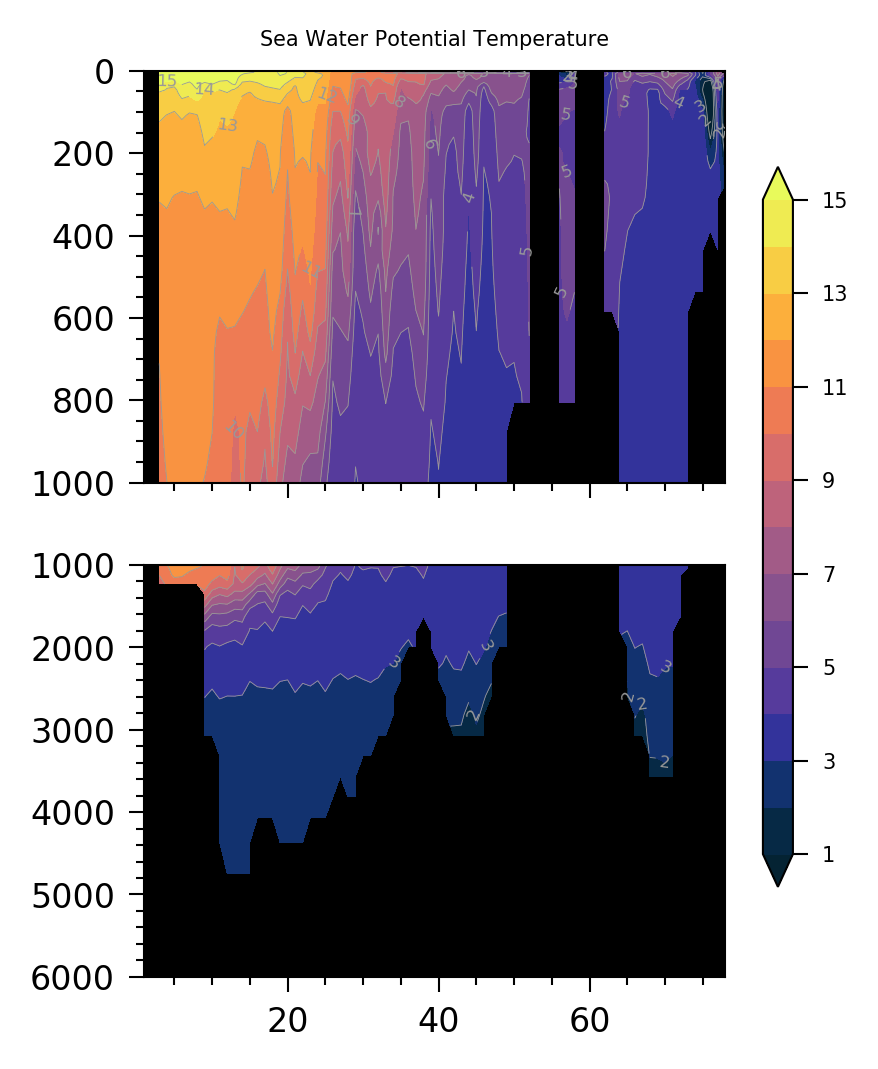

In [12]:
plot_section(ds_obs[ovar_name],  cprops= {'thetao':(1,15,cmocean.cm.thermal,14,100,1e3)})

# Model

(<Figure size 750x1200 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1e5062ddd8>)

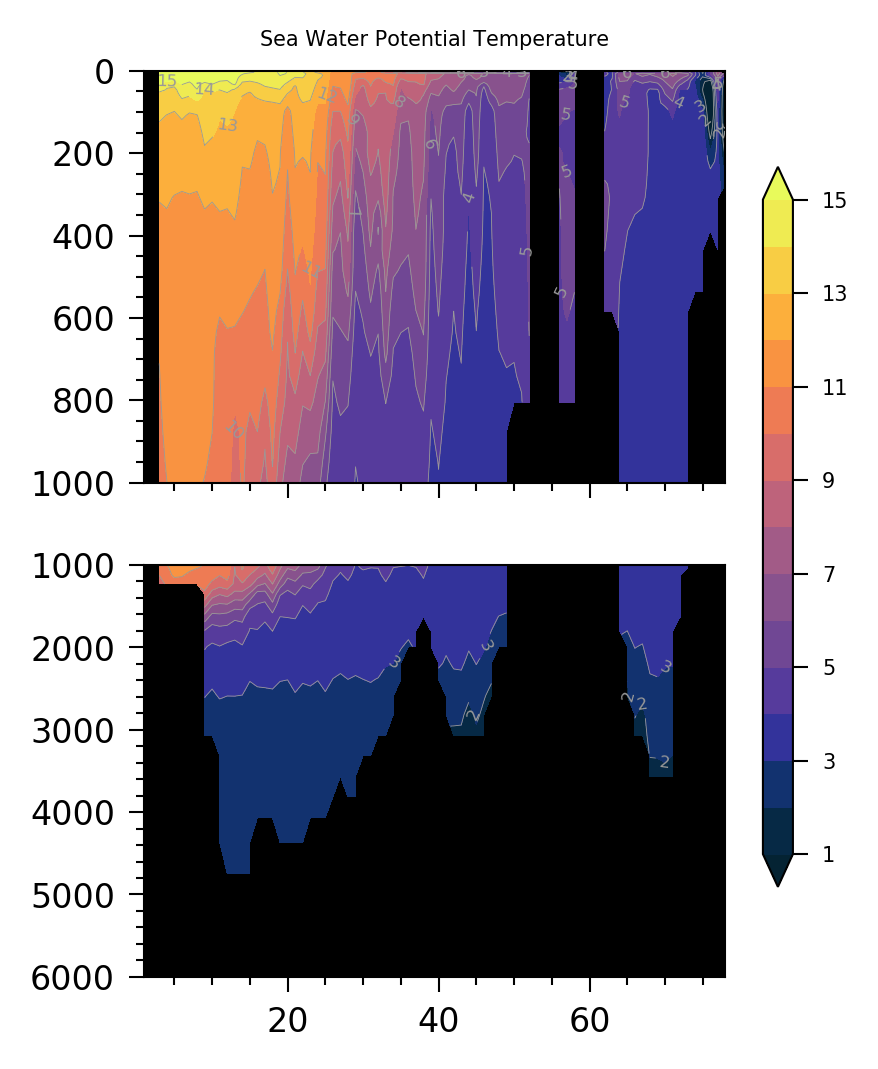

In [13]:
plot_section(ds_obs[ovar_name],cprops= {'thetao':(1,15,cmocean.cm.thermal,14,100,1e3)})

# Model-Data difference

(<Figure size 750x1200 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1deefa7518>)

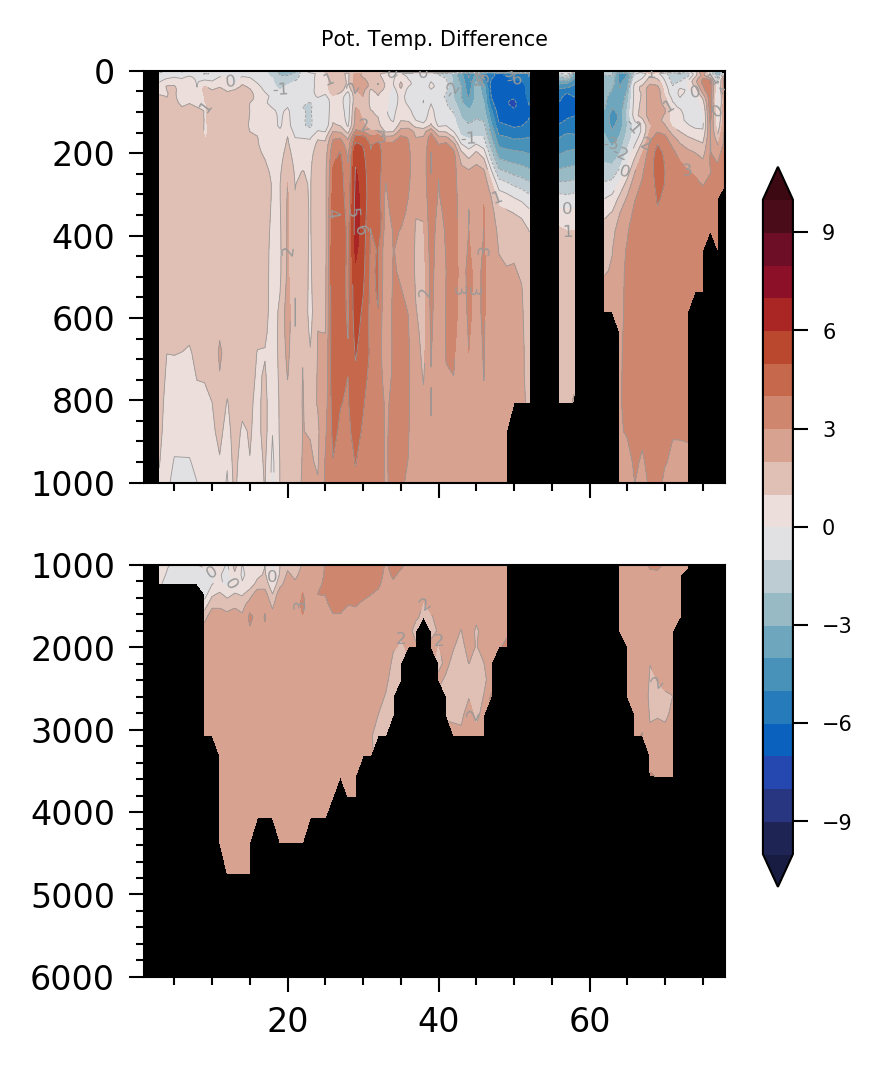

In [14]:
ds_model['station'] = ds_obs['station']

delta = ds_model[ovar_name]-ds_obs[ovar_name]
delta.attrs['long_name'] = 'Pot. Temp. Difference'
plot_section(delta,cprops= {'thetao':(-10,10,cmocean.cm.balance,20,100,1e3)})

# Issues
- Some sections don't interpolate correctly; interpolation of observations needs to be improved
- Address different model coordinates names and units
- Improve perfomance of interpolation of one realization
